In [1]:
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False

In [2]:
%matplotlib inline

In [3]:
from pprint import pprint
from datetime import datetime, timedelta
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl

import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.utils import plot_model

tfk = tf.keras
tfkl = tf.keras.layers

from market_trading.markets.BTCMarketSimulator import BTCMarketSimulator
from market_trading.traders.simple_traders import SimpleTrader

In [4]:
market = BTCMarketSimulator(
    int(datetime(year=2020, month=1, day=1).timestamp()),
    '../data/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv'
)

In [5]:
market.btc_df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1577833200,7175.39,7175.39,7171.23,7175.39,0.518345,3719.279130,7175.302717
1,1577833260,7175.39,7175.39,7175.39,7175.39,0.115856,831.310979,7175.390000
2,1577833320,7172.96,7178.31,7172.96,7173.86,0.860977,6177.965010,7175.531260
3,1577833380,7170.76,7171.94,7166.25,7166.25,7.476673,53603.857655,7169.480054
4,1577833440,7170.44,7170.44,7170.44,7170.44,0.025002,179.271899,7170.440000


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices = market.btc_df.Close.interpolate().values.reshape(-1, 1)
prices_scaled = scaler.fit_transform(prices)

In [17]:
TRAIN_INTERVAL = 10 # minutes 
TRAIN_WIN = 60 # how many point to loop back
TRAIN_PORTION = .9

In [18]:
indices = [i for i in range(0, prices_scaled.shape[0], TRAIN_INTERVAL)]
data = prices[indices, :]
data_scaled =prices_scaled[indices, :]
n_train = int(data_scaled.shape[0]*TRAIN_PORTION)

train_data = prices_scaled[:n_train, :]

x_train = []
y_train = []

for i in range(TRAIN_WIN, len(train_data)):
    x_train.append(train_data[i - TRAIN_WIN:i, :])
    y_train.append(train_data[i, :])
    
x_train, y_train = np.array(x_train), np.array(y_train)

In [19]:
model = tfk.Sequential([
    tfkl.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
#     tfkl.LSTM(units=50, return_sequences=True),
    tfkl.LSTM(units=50, return_sequences=False),
    tfkl.Dense(25),
    tfkl.Dense(1)    
])

model.compile(optimizer='adam', loss='mse')

In [20]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

47250/47250 [==============================] - 677s 14ms/step - loss: 2.3377e-05


In [11]:
with open('scaler.pkl', mode='wb') as f:
    pkl.dump(scaler, f)
    
model.save(f'lstml_2020_1_9_{TRAIN_INTERVAL}')

INFO:tensorflow:Assets written to: lstml_2020_1_9_10/assets


INFO:tensorflow:Assets written to: lstml_2020_1_9_10/assets


In [10]:
model = tfk.models.load_model('lstml_2020_1_9')

In [21]:
test_data = data_scaled[n_train - TRAIN_WIN: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  data[n_train: , : ] 
for i in range(TRAIN_WIN,len(test_data)):
    x_test.append(test_data[i - TRAIN_WIN:i,:])

x_test = np.array(x_test)

In [22]:
x_test.shape

(5257, 60, 1)

In [23]:
predictions = scaler.inverse_transform(
    model.predict(x_test)
)

In [24]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1538.2550486539983

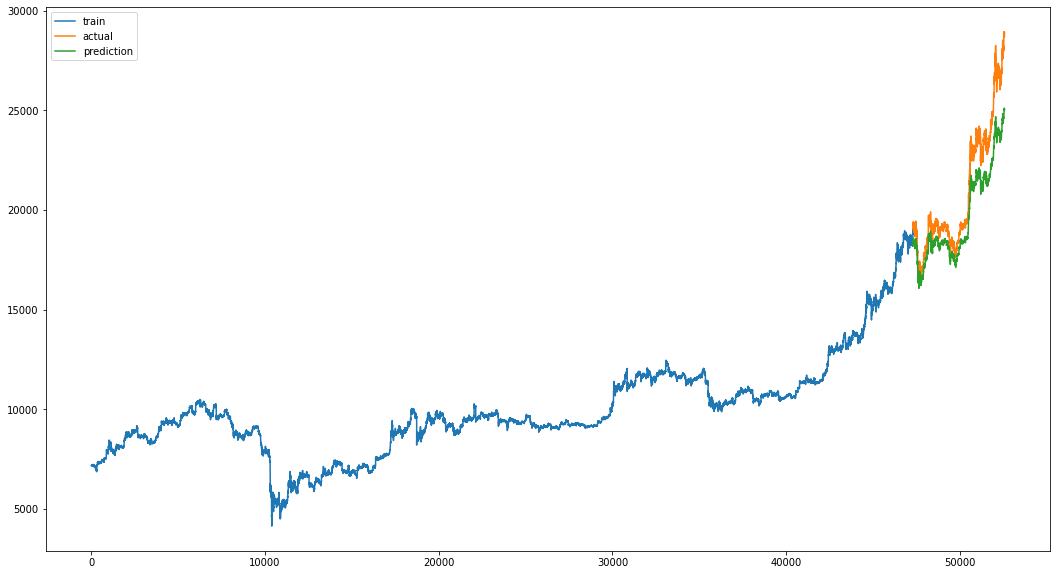

In [25]:
train = data[:n_train]
actual = data[n_train:]

#Visualize the data
plt.figure(figsize=(18,10))
plt.plot(list(range(n_train)), train, label='train')
plt.plot(list(range(n_train, n_train + len(actual))), actual, label='actual')
plt.plot(list(range(n_train, n_train + len(actual))), predictions, label='prediction')
plt.legend()
plt.show()